# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/vit_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [5]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
      201547  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
      201548  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
      201549  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
      201550  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   

                     6         7      8         9  ...       759      760  \
41001 201546 -0.093779  0.015505  0.614 -0.552001  ... -0.805507  0.21285   
      201547 -0.093779  0.015505  0.614 -0.552001  ... -0.805507  0.21285   
      201548 -0.093779  0.015505  0.614 -0.552001  ... -0.805507  0.21285   
      201549 -0.093779  0.015505  0.614 -0.552001  ... -0.805507  0.21285   
      201550 -0.093779  0.015505  0.614 -0.552001  ... -0.805507  0.21285   

                   761       762       763       764       765       766  \
41001 201546  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
      201547  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
      201548  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
      201549  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
      201550  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   

                   767    Labels  
41001 201546  0.014199 -0.861740  
      201547  0.014199 -0.854589  
      201548  0.014199 -0.856973  
      201549  0.014199 -0.856973  
      201550  0.014199 -0.823600  

[5 rows x 769 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0         1         2         3         4         5  \
5360 201546  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
     201547 -0.320510  0.119825  0.137270  0.216795 -0.476022  0.158546   
     201548  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   
     201549 -0.444779  0.071139  0.012459 -0.366217 -0.225480 -0.081610   
     201550  0.592657 -0.041825 -0.059889 -0.038526 -0.306822  0.033433   

                    6         7         8         9  ...       759       760  \
5360 201546 -0.093779  0.015505  0.614000 -0.552001  ... -0.805507  0.212850   
     201547 -0.570430 -0.044212  0.344147 -0.219893  ... -0.319999  0.582625   
     201548 -0.093779  0.015505  0.614000 -0.552001  ... -0.805507  0.212850   
     201549 -0.170546 -0.254429  0.199990 -0.249487  ...  0.342236  0.245481   
     201550 -0.093779  0.015505  0.614000 -0.552001  ... -0.805507  0.212850   

                  761       762       763       764       765       766  \
5360 201546  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
     201547  0.144274 -0.023346  0.200789 -0.030519  0.321033 -0.225532   
     201548  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   
     201549  0.160376 -0.515343  0.231088  0.428935  0.251430 -0.283586   
     201550  0.738938  0.237695  0.577764  0.634531 -0.514114  0.107294   

                  767    Labels  
5360 201546  0.014199 -0.990465  
     201547  0.463084 -0.969011  
     201548  0.014199 -0.995232  
     201549  0.161517 -0.997616  
     201550  0.014199 -0.971395  

[5 rows x 769 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 769)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 768)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 768)
The shape of the labels is (326, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

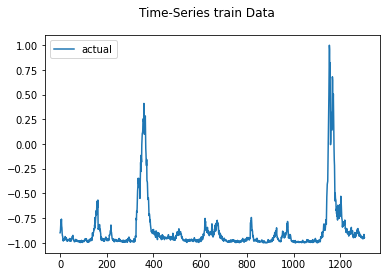

2023-03-04 23:52:16.690807: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-04 23:52:16.690863: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-04 23:52:16.690887: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-04 23:52:16.691154: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 23:52:16.819987: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 42.836
Test sMAPE: 137.732
Test RMSE: 54.925
{'mae': 42.83601019014976, 'smape': 137.73227442360198, 'rmse': 54.925350542828525}


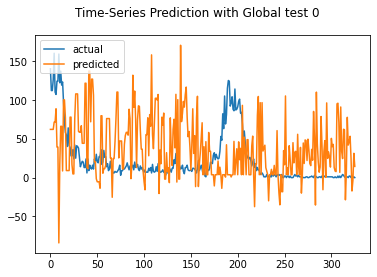

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 59.134
Test sMAPE: 132.904
Test RMSE: 70.767
{'mae': 59.13417974864047, 'smape': 132.9039963752658, 'rmse': 70.76718536273536}


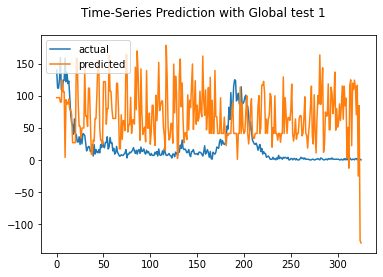

Test MAE: 93.143
Test sMAPE: 157.975
Test RMSE: 107.096
{'mae': 93.14339552188943, 'smape': 157.97525494748064, 'rmse': 107.09557364956815}


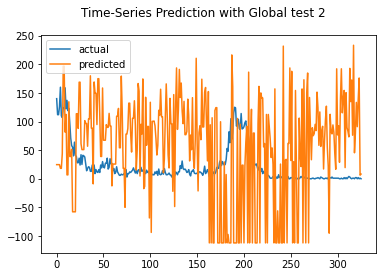

Test MAE: 41.032
Test sMAPE: 123.390
Test RMSE: 50.128
{'mae': 41.03169418185767, 'smape': 123.38972681104539, 'rmse': 50.12834688470946}


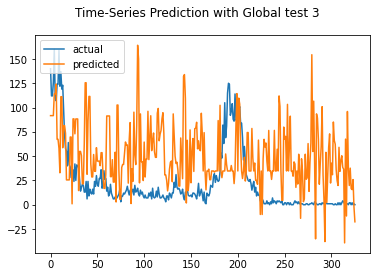

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 49.786
Test sMAPE: 131.375
Test RMSE: 59.232
{'mae': 49.786105657647724, 'smape': 131.37471413528056, 'rmse': 59.23200978369798}


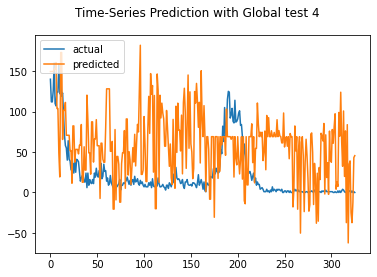

Test MAE: 53.648
Test sMAPE: 135.435
Test RMSE: 62.062
{'mae': 53.648124888996406, 'smape': 135.434569943664, 'rmse': 62.06198767251736}


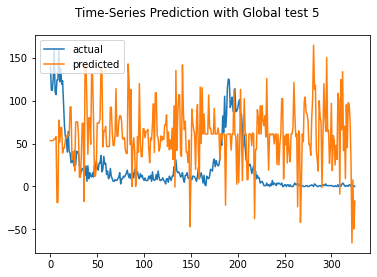

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 44.469
Test sMAPE: 130.470
Test RMSE: 54.513
{'mae': 44.46859336411295, 'smape': 130.4698594019207, 'rmse': 54.513291376791436}


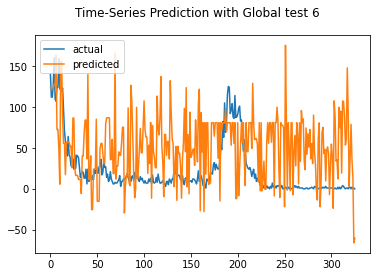

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 49.177
Test sMAPE: 137.279
Test RMSE: 59.805
{'mae': 49.17670722461185, 'smape': 137.27884827669396, 'rmse': 59.80462405968803}


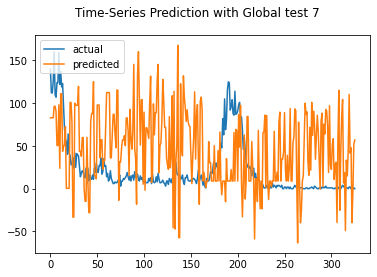

Test MAE: 67.612
Test sMAPE: 159.185
Test RMSE: 85.873
{'mae': 67.61222720694688, 'smape': 159.1845407788289, 'rmse': 85.87277513923117}


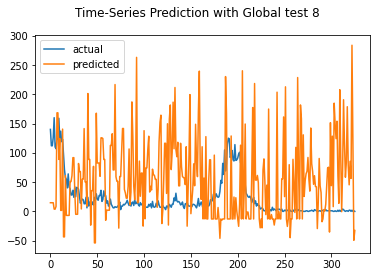

Test MAE: 70.920
Test sMAPE: 147.267
Test RMSE: 95.537
{'mae': 70.92000729540375, 'smape': 147.26692735900244, 'rmse': 95.53696531104876}


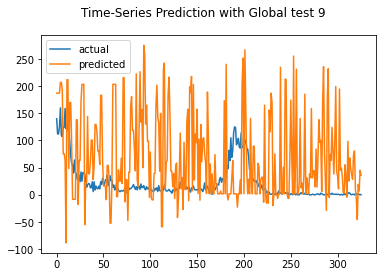

Test MAE: 65.167
Test sMAPE: 147.776
Test RMSE: 78.475
{'mae': 65.16669850407933, 'smape': 147.77564506200162, 'rmse': 78.47488844814468}


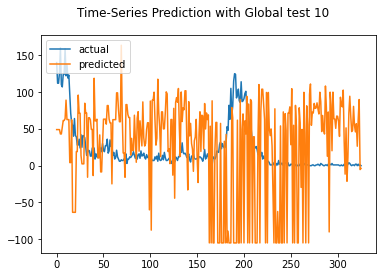

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 49.119
Test sMAPE: 138.479
Test RMSE: 60.683
{'mae': 49.1192426260995, 'smape': 138.47871013565444, 'rmse': 60.68266633663507}


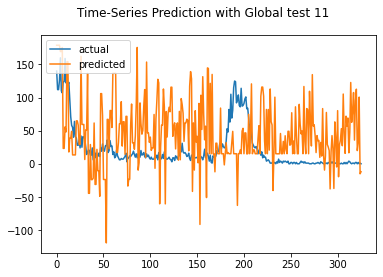

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 59.007
Test sMAPE: 144.984
Test RMSE: 74.279
{'mae': 59.007349996387596, 'smape': 144.98371037732306, 'rmse': 74.27852248144349}


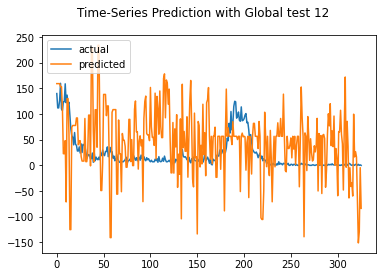

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 49.652
Test sMAPE: 136.591
Test RMSE: 60.864
{'mae': 49.65225040912628, 'smape': 136.59119981884766, 'rmse': 60.86368170349477}


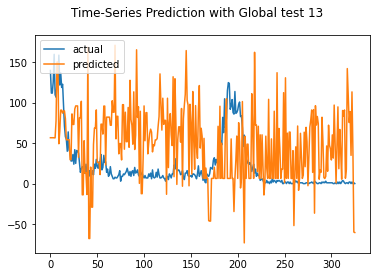

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 49.702
Test sMAPE: 132.907
Test RMSE: 59.844
{'mae': 49.70174682405463, 'smape': 132.9065959536442, 'rmse': 59.84401429851292}


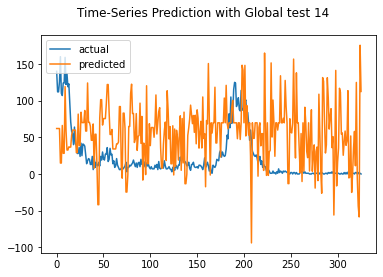

Test MAE: 78.676
Test sMAPE: 140.861
Test RMSE: 100.989
{'mae': 78.67572445134444, 'smape': 140.86117074010338, 'rmse': 100.98939745361382}


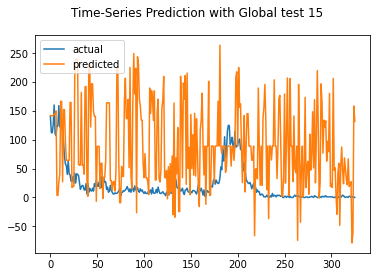

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 60.096
Test sMAPE: 138.402
Test RMSE: 74.249
{'mae': 60.09637449252094, 'smape': 138.40161719742804, 'rmse': 74.24915812237312}


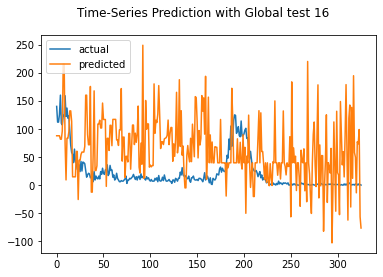

Test MAE: 68.511
Test sMAPE: 150.837
Test RMSE: 77.410
{'mae': 68.51098993438885, 'smape': 150.83684420394783, 'rmse': 77.40994415930889}


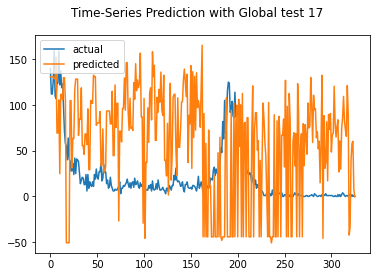

Test MAE: 55.545
Test sMAPE: 131.389
Test RMSE: 63.622
{'mae': 55.54492658980054, 'smape': 131.38860809521194, 'rmse': 63.62193093006392}


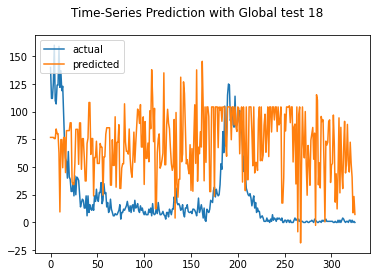

Test MAE: 76.980
Test sMAPE: 155.223
Test RMSE: 85.182
{'mae': 76.97960361289832, 'smape': 155.22268964597973, 'rmse': 85.1815654192686}


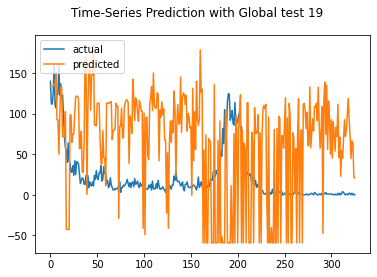

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 47.083
Test sMAPE: 138.256
Test RMSE: 58.225
{'mae': 47.08256149438261, 'smape': 138.2564466845465, 'rmse': 58.22521579905897}


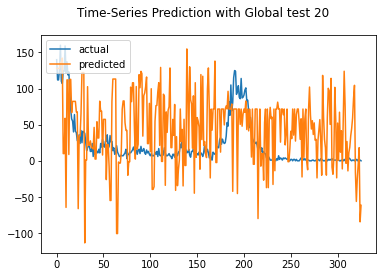

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 51.102
Test sMAPE: 144.291
Test RMSE: 62.133
{'mae': 51.10234068023281, 'smape': 144.2905799544128, 'rmse': 62.1334279630542}


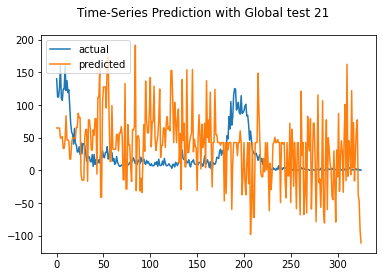

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 52.499
Test sMAPE: 133.380
Test RMSE: 63.059
{'mae': 52.499121970742756, 'smape': 133.37987661482114, 'rmse': 63.059195211952165}


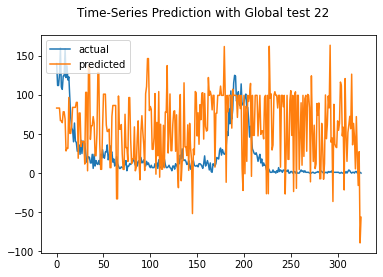

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 49.994
Test sMAPE: 145.060
Test RMSE: 63.365
{'mae': 49.994494277275415, 'smape': 145.06002999145514, 'rmse': 63.365011389589206}


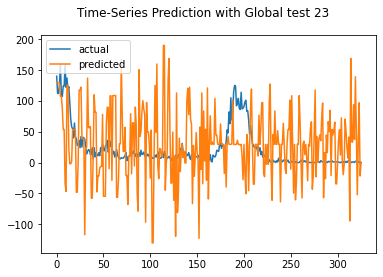

Test MAE: 84.094
Test sMAPE: 149.262
Test RMSE: 96.826
{'mae': 84.09356172794213, 'smape': 149.26235049565352, 'rmse': 96.82630362578239}


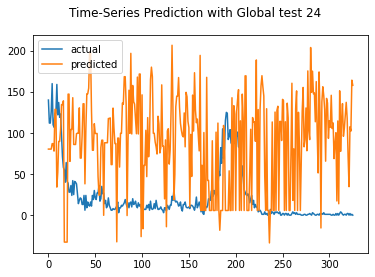

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 47.719
Test sMAPE: 135.991
Test RMSE: 60.702
{'mae': 47.71868961747804, 'smape': 135.99132343893464, 'rmse': 60.702069577717495}


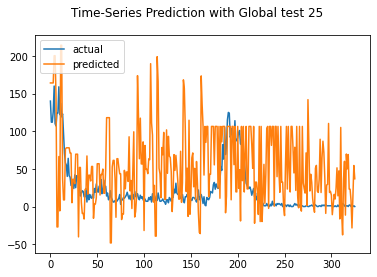

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 53.736
Test sMAPE: 134.979
Test RMSE: 65.965
{'mae': 53.73573460571605, 'smape': 134.97866926738297, 'rmse': 65.9652923918377}


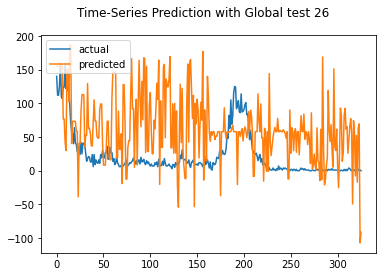

Test MAE: 55.955
Test sMAPE: 130.322
Test RMSE: 66.100
{'mae': 55.9550876800268, 'smape': 130.32200372505153, 'rmse': 66.10023923905928}


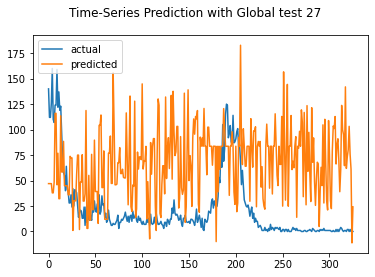

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 47.514
Test sMAPE: 140.361
Test RMSE: 59.560
{'mae': 47.51389485195371, 'smape': 140.36050196628895, 'rmse': 59.56024423717018}


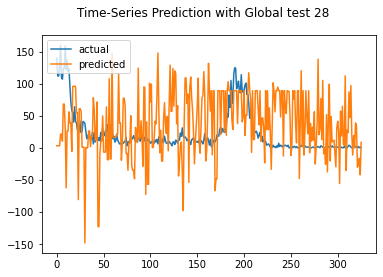

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 65.409
Test sMAPE: 146.902
Test RMSE: 84.817
{'mae': 65.40883073960345, 'smape': 146.90249874839373, 'rmse': 84.81691398735045}


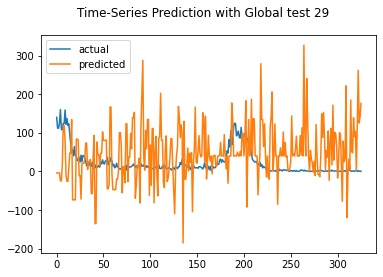

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 53.076
Test sMAPE: 138.469
Test RMSE: 66.732
{'mae': 53.07599424913617, 'smape': 138.46945571122413, 'rmse': 66.73202432435073}


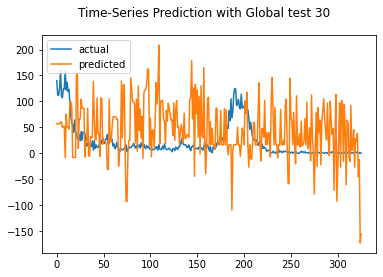

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 50.118
Test sMAPE: 135.307
Test RMSE: 60.766
{'mae': 50.11807996308877, 'smape': 135.30725202340668, 'rmse': 60.76583925426014}


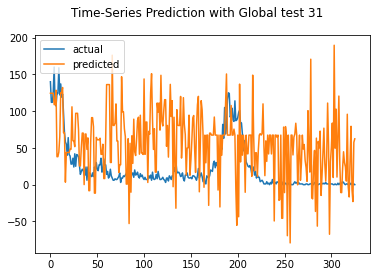

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 54.813
Test sMAPE: 140.778
Test RMSE: 66.350
{'mae': 54.813353543449765, 'smape': 140.7780234841851, 'rmse': 66.35015177022969}


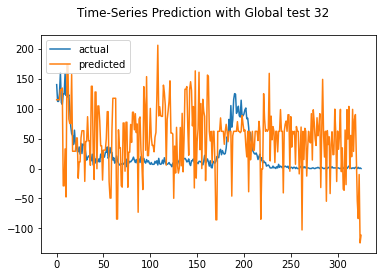

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 44.500
Test sMAPE: 138.908
Test RMSE: 55.029
{'mae': 44.50025093153211, 'smape': 138.9079128991758, 'rmse': 55.02916836520043}


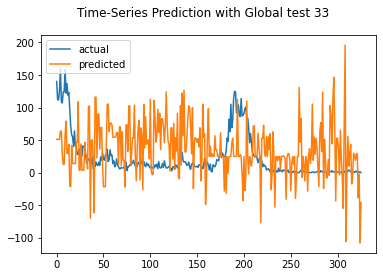

Test MAE: 57.952
Test sMAPE: 134.630
Test RMSE: 68.060
{'mae': 57.95196323179029, 'smape': 134.62968389361134, 'rmse': 68.06041791868134}


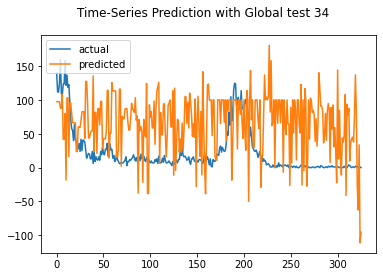

Test MAE: 57.424
Test sMAPE: 149.677
Test RMSE: 70.305
{'mae': 57.42413173588507, 'smape': 149.67653975952857, 'rmse': 70.30481868414155}


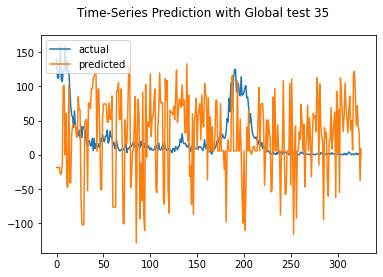

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 56.807
Test sMAPE: 140.034
Test RMSE: 67.501
{'mae': 56.80660133310622, 'smape': 140.03376832971185, 'rmse': 67.50050097225342}


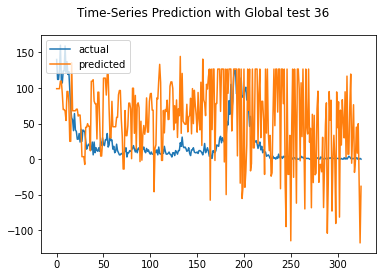

Test MAE: 81.867
Test sMAPE: 155.167
Test RMSE: 99.373
{'mae': 81.86725544746668, 'smape': 155.16678877229143, 'rmse': 99.37292062114251}


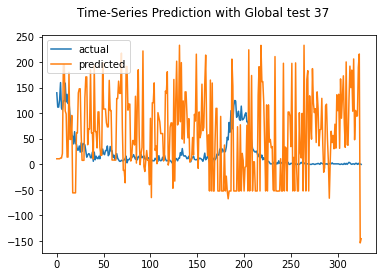

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 54.716
Test sMAPE: 138.440
Test RMSE: 67.300
{'mae': 54.7160489410162, 'smape': 138.4404966160082, 'rmse': 67.30022681885016}


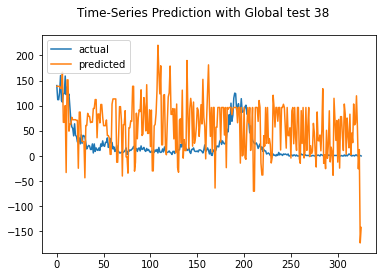

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 52.765
Test sMAPE: 131.792
Test RMSE: 62.155
{'mae': 52.76513109141332, 'smape': 131.79195689656848, 'rmse': 62.15503213100136}


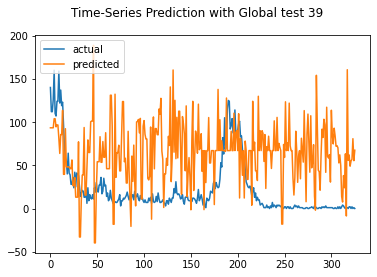

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 53.219
Test sMAPE: 139.042
Test RMSE: 66.784
{'mae': 53.21863369506561, 'smape': 139.04174044998285, 'rmse': 66.78374695380496}


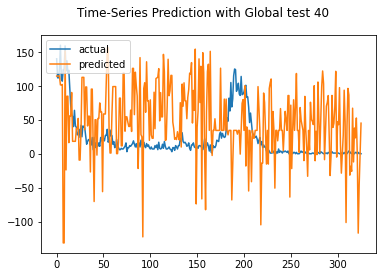

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 46.602
Test sMAPE: 132.389
Test RMSE: 55.972
{'mae': 46.60178116128488, 'smape': 132.38922629306975, 'rmse': 55.97174131314143}


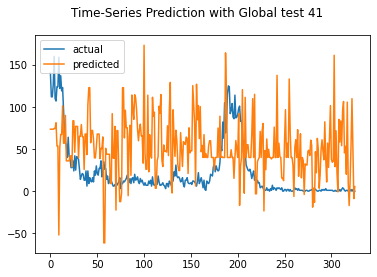

Test MAE: 122.790
Test sMAPE: 168.751
Test RMSE: 140.816
{'mae': 122.79020780142099, 'smape': 168.7509624644752, 'rmse': 140.81620958113433}


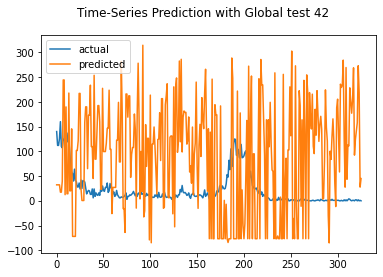

Test MAE: 60.901
Test sMAPE: 136.123
Test RMSE: 69.751
{'mae': 60.901348391559225, 'smape': 136.12267307167363, 'rmse': 69.75069698191992}


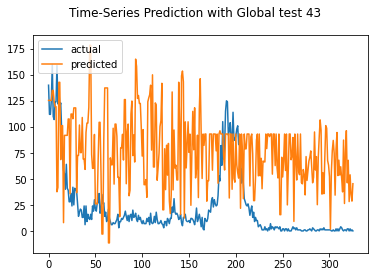

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 50.296
Test sMAPE: 130.429
Test RMSE: 60.665
{'mae': 50.2963126641841, 'smape': 130.42861832121937, 'rmse': 60.66502281771868}


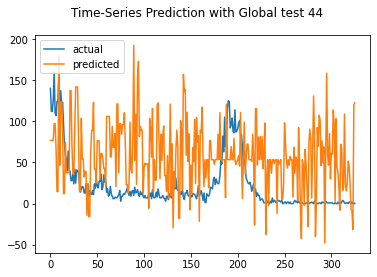

Test MAE: 104.916
Test sMAPE: 162.906
Test RMSE: 114.285
{'mae': 104.915614404927, 'smape': 162.9062090541854, 'rmse': 114.2850524275797}


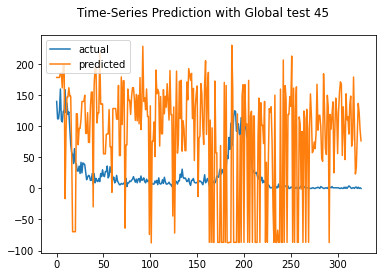

Test MAE: 52.346
Test sMAPE: 133.000
Test RMSE: 61.378
{'mae': 52.346233445076855, 'smape': 133.00045110324706, 'rmse': 61.37795346116813}


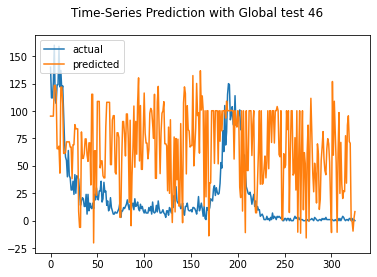

Test MAE: 62.805
Test sMAPE: 140.423
Test RMSE: 75.919
{'mae': 62.80543685507921, 'smape': 140.42324217033448, 'rmse': 75.919140421366}


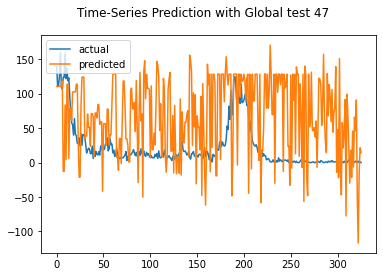

Test MAE: 66.743
Test sMAPE: 142.060
Test RMSE: 82.470
{'mae': 66.74282823439025, 'smape': 142.06039869030616, 'rmse': 82.47002050079281}


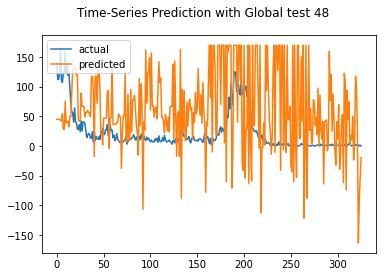

Test MAE: 54.816
Test sMAPE: 136.336
Test RMSE: 68.600
{'mae': 54.81638048488669, 'smape': 136.33596143840404, 'rmse': 68.59970902393329}


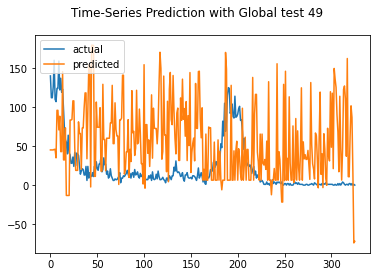

Test MAE: 63.818
Test sMAPE: 137.912
Test RMSE: 78.871
{'mae': 63.818492933285015, 'smape': 137.9121897630613, 'rmse': 78.8713850320783}


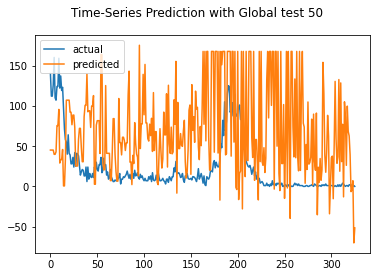

Test MAE: 58.739
Test sMAPE: 136.335
Test RMSE: 67.233
{'mae': 58.73888425885534, 'smape': 136.33480784496035, 'rmse': 67.23283797045777}


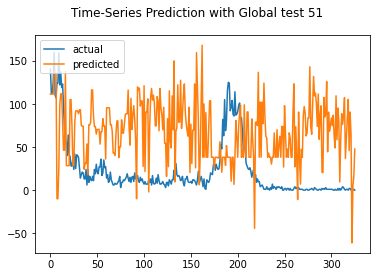

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 51.695
Test sMAPE: 139.412
Test RMSE: 62.030
{'mae': 51.69513262927167, 'smape': 139.41150903597898, 'rmse': 62.03007852726089}


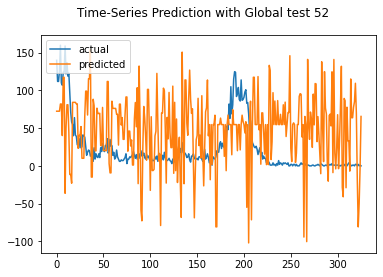

Test MAE: 75.008
Test sMAPE: 149.848
Test RMSE: 87.945
{'mae': 75.00803468508954, 'smape': 149.84766845846084, 'rmse': 87.94474160069525}


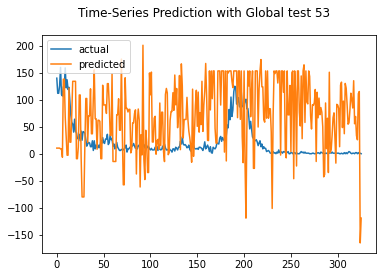

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 49.589
Test sMAPE: 140.449
Test RMSE: 62.580
{'mae': 49.58853195744789, 'smape': 140.44930865271283, 'rmse': 62.57952677122781}


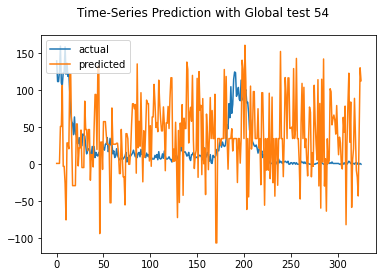

Test MAE: 97.551
Test sMAPE: 155.241
Test RMSE: 112.505
{'mae': 97.55077904170277, 'smape': 155.2406684279955, 'rmse': 112.50527229792806}


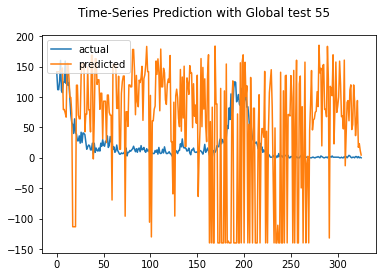

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 48.207
Test sMAPE: 132.131
Test RMSE: 59.119
{'mae': 48.206543311019615, 'smape': 132.13077233769292, 'rmse': 59.11882286105697}


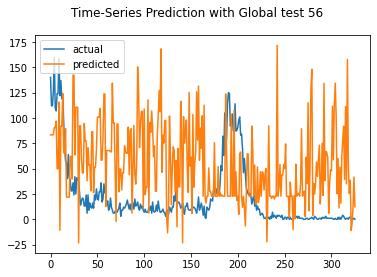

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 38.800
Test sMAPE: 132.230
Test RMSE: 46.296
{'mae': 38.80047214076929, 'smape': 132.23041117690244, 'rmse': 46.296266127786936}


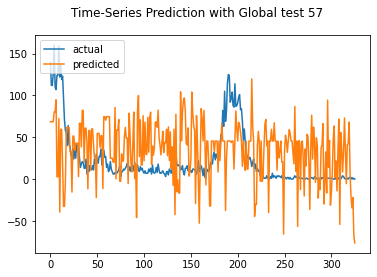

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 57.929
Test sMAPE: 144.516
Test RMSE: 72.223
{'mae': 57.9291828607489, 'smape': 144.5162402272698, 'rmse': 72.22295594863952}


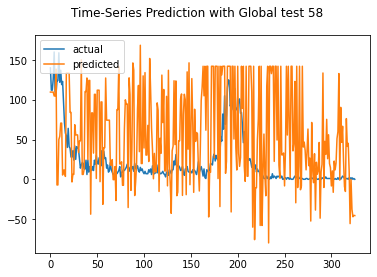

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 43.254
Test sMAPE: 141.084
Test RMSE: 54.492
{'mae': 43.253636072018395, 'smape': 141.08384435334386, 'rmse': 54.49201217002706}


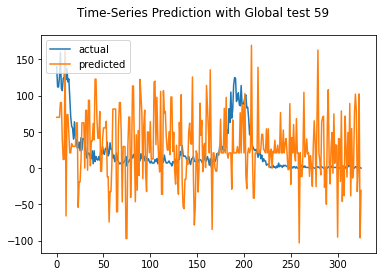

Test MAE: 61.436
Test sMAPE: 138.427
Test RMSE: 74.399
{'mae': 61.435529951668954, 'smape': 138.4272250302617, 'rmse': 74.39946520571502}


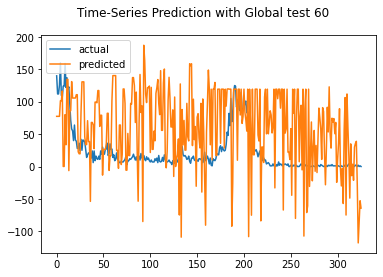

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 43.126
Test sMAPE: 151.649
Test RMSE: 56.724
{'mae': 43.125987094787, 'smape': 151.64899027316014, 'rmse': 56.72353693433359}


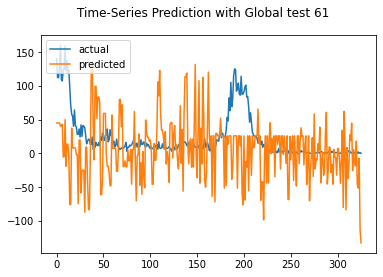

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 43.199
Test sMAPE: 142.989
Test RMSE: 57.302
{'mae': 43.19889687394803, 'smape': 142.98918930633047, 'rmse': 57.30237501150052}


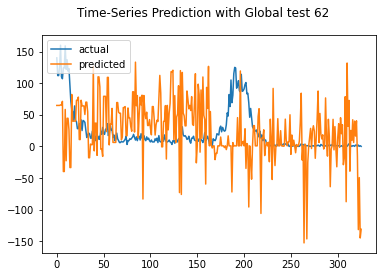

Test MAE: 55.193
Test sMAPE: 135.182
Test RMSE: 64.489
{'mae': 55.19292358167333, 'smape': 135.1821330562028, 'rmse': 64.48948055538904}


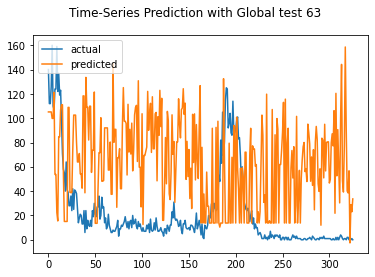

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 52.371
Test sMAPE: 138.598
Test RMSE: 67.446
{'mae': 52.371156190070636, 'smape': 138.5982940255539, 'rmse': 67.44573946461266}


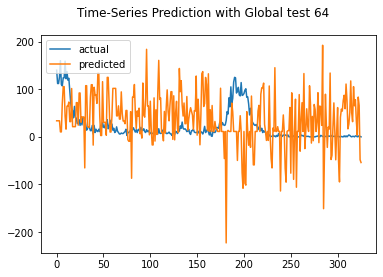

Test MAE: 74.053
Test sMAPE: 157.138
Test RMSE: 89.394
{'mae': 74.05270433572173, 'smape': 157.13783200874605, 'rmse': 89.39406091374859}


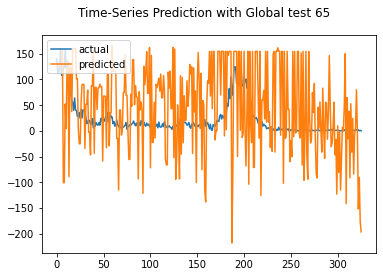

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 48.482
Test sMAPE: 136.243
Test RMSE: 61.123
{'mae': 48.48248679835372, 'smape': 136.24348293720934, 'rmse': 61.122901557909195}


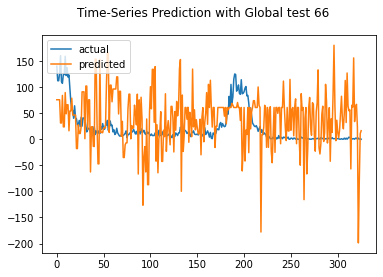

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 48.003
Test sMAPE: 129.746
Test RMSE: 57.669
{'mae': 48.003462051687066, 'smape': 129.7460045114127, 'rmse': 57.66891715844368}


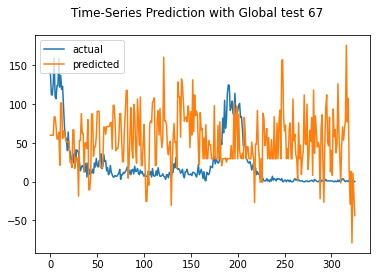

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 64.971
Test sMAPE: 142.940
Test RMSE: 79.706
{'mae': 64.97126655545702, 'smape': 142.93961564577526, 'rmse': 79.70645251645588}


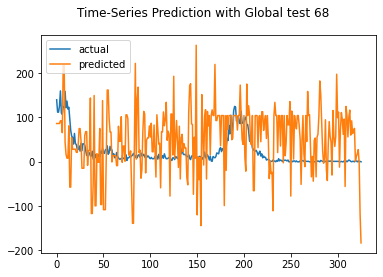

Test MAE: 47.337
Test sMAPE: 126.921
Test RMSE: 57.004
{'mae': 47.33721620319811, 'smape': 126.92096716868929, 'rmse': 57.00374397275462}


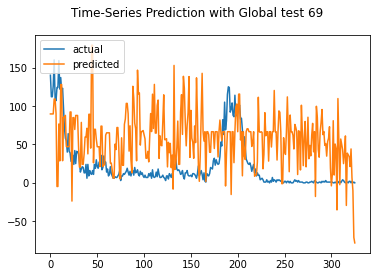

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 41.287
Test sMAPE: 129.069
Test RMSE: 50.581
{'mae': 41.287200646349255, 'smape': 129.06922383601997, 'rmse': 50.580864708493536}


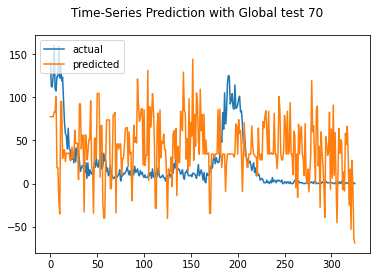

Test MAE: 64.864
Test sMAPE: 143.950
Test RMSE: 81.025
{'mae': 64.8637197421738, 'smape': 143.9503641423259, 'rmse': 81.02532968767558}


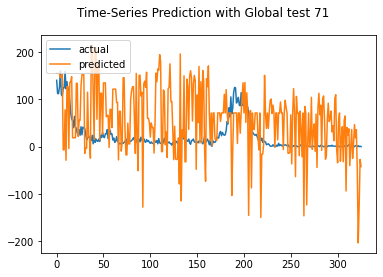

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 60.240
Test sMAPE: 137.828
Test RMSE: 71.179
{'mae': 60.24032645540004, 'smape': 137.82751617160366, 'rmse': 71.17878364103356}


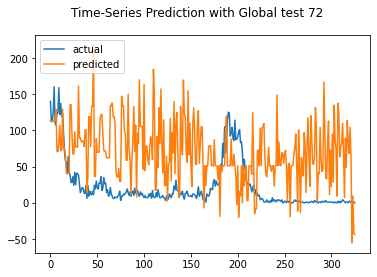

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 49.938
Test sMAPE: 134.796
Test RMSE: 61.008
{'mae': 49.93829748948659, 'smape': 134.79584824205799, 'rmse': 61.007556702835}


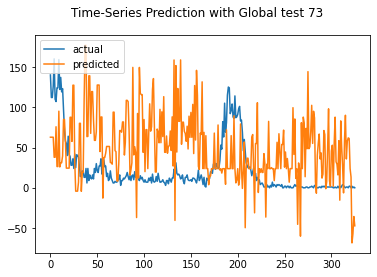

Test MAE: 59.357
Test sMAPE: 139.283
Test RMSE: 72.535
{'mae': 59.356502171674386, 'smape': 139.2827422323948, 'rmse': 72.53481294593264}


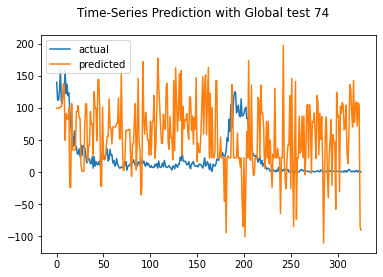

Test MAE: 95.928
Test sMAPE: 155.426
Test RMSE: 119.429
{'mae': 95.92802373726676, 'smape': 155.42583715662892, 'rmse': 119.42910374153261}


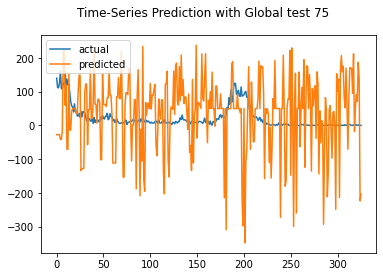

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 58.053
Test sMAPE: 141.350
Test RMSE: 71.200
{'mae': 58.05289313325121, 'smape': 141.35046385019865, 'rmse': 71.20047917344412}


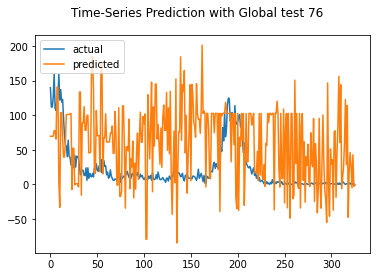

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 49.369
Test sMAPE: 132.707
Test RMSE: 59.076
{'mae': 49.36945488994107, 'smape': 132.70654072128102, 'rmse': 59.07597122560528}


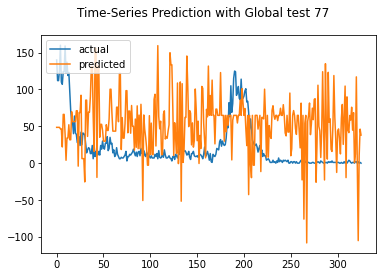

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 52.171
Test sMAPE: 143.276
Test RMSE: 66.285
{'mae': 52.170780633124835, 'smape': 143.27649123171324, 'rmse': 66.2849223925957}


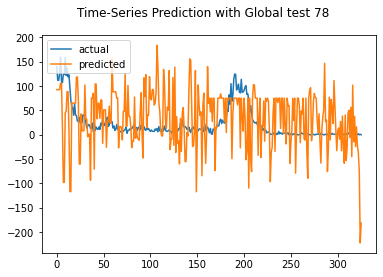

Test MAE: 66.153
Test sMAPE: 149.600
Test RMSE: 79.989
{'mae': 66.15306612392145, 'smape': 149.6002524245106, 'rmse': 79.98851758016147}


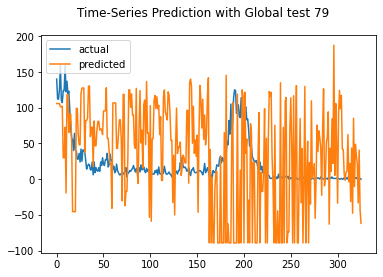

Test MAE: 59.520
Test sMAPE: 137.097
Test RMSE: 71.706
{'mae': 59.52004295761234, 'smape': 137.0968518350544, 'rmse': 71.70587144633767}


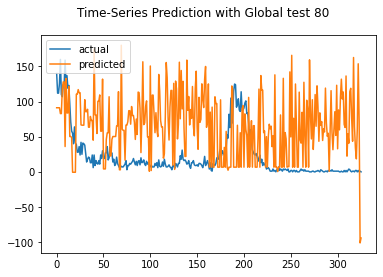

Test MAE: 84.814
Test sMAPE: 154.093
Test RMSE: 109.950
{'mae': 84.81389368494595, 'smape': 154.09345511484506, 'rmse': 109.94952376831755}


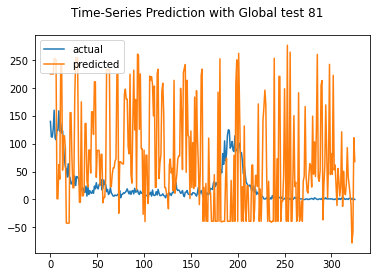

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 38.441
Test sMAPE: 126.527
Test RMSE: 47.262
{'mae': 38.441107016216755, 'smape': 126.52655166268009, 'rmse': 47.26178604072721}


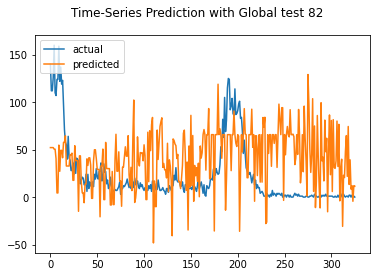

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 58.700
Test sMAPE: 148.455
Test RMSE: 71.792
{'mae': 58.70005589915565, 'smape': 148.4545039664657, 'rmse': 71.7924465978934}


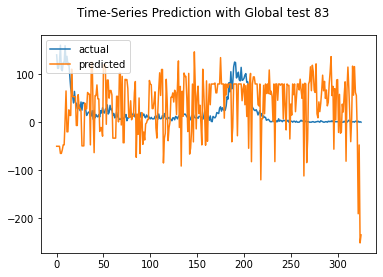

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 46.456
Test sMAPE: 133.822
Test RMSE: 55.914
{'mae': 46.45621281167481, 'smape': 133.82173854937963, 'rmse': 55.9135523223229}


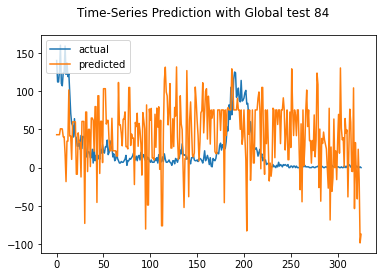

Test MAE: 70.877
Test sMAPE: 145.818
Test RMSE: 81.836
{'mae': 70.87731563423309, 'smape': 145.81839657488732, 'rmse': 81.83641476857994}


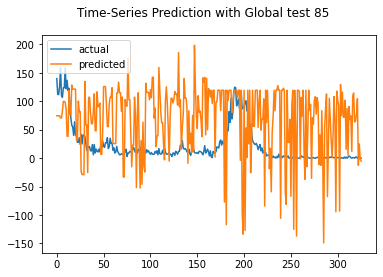

Test MAE: 83.215
Test sMAPE: 153.472
Test RMSE: 97.507
{'mae': 83.21517746945831, 'smape': 153.47241227278639, 'rmse': 97.50744134553646}


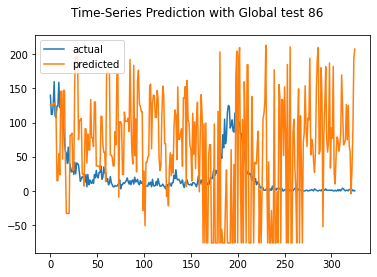

Test MAE: 74.335
Test sMAPE: 152.489
Test RMSE: 85.670
{'mae': 74.33542232974175, 'smape': 152.4886732773728, 'rmse': 85.66998217438447}


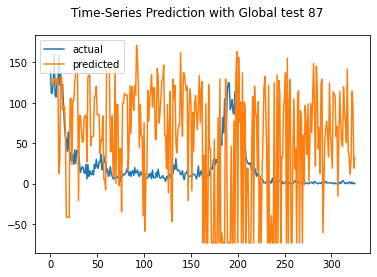

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 52.506
Test sMAPE: 133.780
Test RMSE: 63.738
{'mae': 52.50597790157868, 'smape': 133.77952289384822, 'rmse': 63.737744181257554}


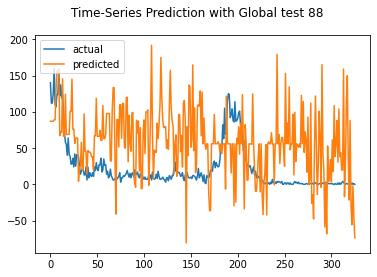

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 61.017
Test sMAPE: 135.174
Test RMSE: 72.262
{'mae': 61.01736031116152, 'smape': 135.17394570464393, 'rmse': 72.26209958667502}


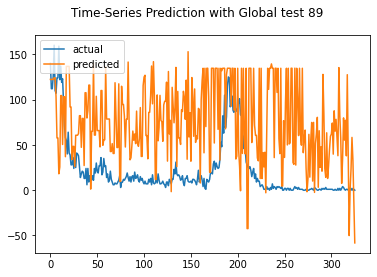

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 44.415
Test sMAPE: 132.720
Test RMSE: 54.295
{'mae': 44.41462285387004, 'smape': 132.71975916052438, 'rmse': 54.29479923389971}


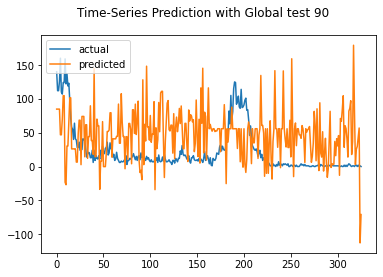

Test MAE: 81.996
Test sMAPE: 143.758
Test RMSE: 95.149
{'mae': 81.99636342737573, 'smape': 143.75806616858193, 'rmse': 95.14943516852405}


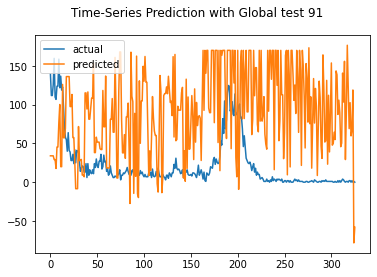

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 55.332
Test sMAPE: 137.758
Test RMSE: 69.585
{'mae': 55.33159094646665, 'smape': 137.75833274633467, 'rmse': 69.58548862655623}


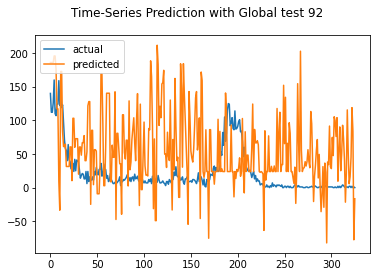

Test MAE: 63.462
Test sMAPE: 150.818
Test RMSE: 74.172
{'mae': 63.4619080455391, 'smape': 150.81753963775748, 'rmse': 74.17159041467862}


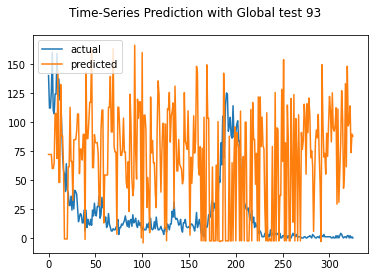

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 47.581
Test sMAPE: 140.570
Test RMSE: 60.718
{'mae': 47.5805477651716, 'smape': 140.56973110227042, 'rmse': 60.71792920229734}


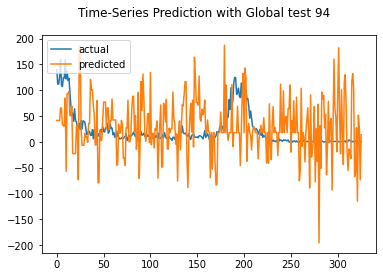

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 51.468
Test sMAPE: 133.049
Test RMSE: 61.337
{'mae': 51.46789485947486, 'smape': 133.048651417048, 'rmse': 61.33731006424562}


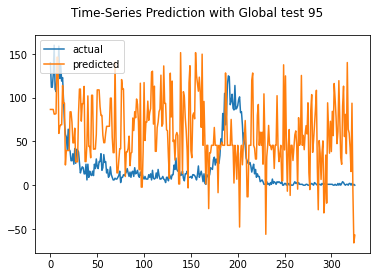

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 57.174
Test sMAPE: 136.933
Test RMSE: 68.837
{'mae': 57.174346803338985, 'smape': 136.93307724606936, 'rmse': 68.83715262525149}


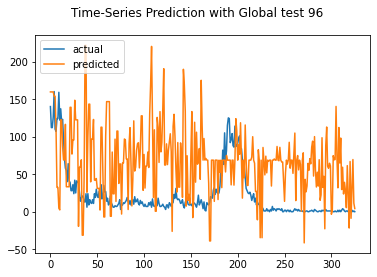

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 53.617
Test sMAPE: 131.442
Test RMSE: 62.903
{'mae': 53.616638744352784, 'smape': 131.4416498923115, 'rmse': 62.90284265053894}


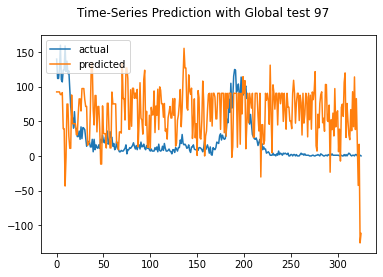

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 51.242
Test sMAPE: 133.493
Test RMSE: 60.557
{'mae': 51.24238269753251, 'smape': 133.49276451250591, 'rmse': 60.557334441597185}


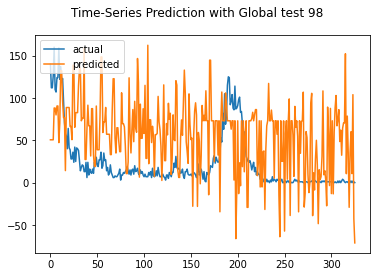

Test MAE: 97.424
Test sMAPE: 156.179
Test RMSE: 114.964
{'mae': 97.42426381246445, 'smape': 156.17880581069892, 'rmse': 114.9644782034663}


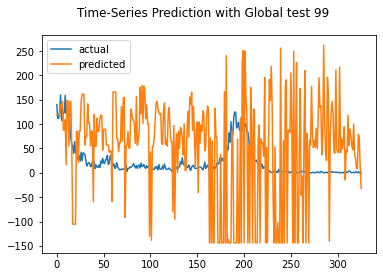

rmse : average=71.775, std=17.194
mae : average=59.325, std=15.151
smape : average=140.676, std=8.699


([71.77510324161337, 17.19380597374049],
 [59.325045684928, 15.15128531074682],
 [140.67644009808998, 8.698590381303822])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
